# Salary Measure and evaluation
Modeling approach to explain win rate

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
plt.rcParams.update({'font.size': 16})

str_dirc = 'GITHUB REPOSITORY AND DATA LOCATION';

# import relevant functions
str_dir_sourceCode = str_origin+"/GitHub/NHL-Analytics/src/measurement"
exec(open(str_dir_sourceCode + "/measurement_teamSuccess.py").read())

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
#model = LogisticRegression(solver='liblinear', random_state=0)
# Or different approach
import numpy as np
import statsmodels.api as sm
# print result in latex
from stargazer.stargazer import Stargazer, LineLocation
from IPython.core.display import HTML

In [3]:
# Function to easily calculate percentile as an object
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

# Pull all historical data

In [ ]:
# Team box score
idx_yr_last = 2022
list_years = np.arange(2011, idx_yr_last)

df = []
for iter in list_years:
    tempdf = pd.read_csv(str_data + f'/processed/{iter}_02_box.csv')
    if iter == 2011:
        df = tempdf
    else:
        df = pd.concat([df, tempdf])

df_box = df

# Team stats pull of season
df_box_season = df_box \
    .groupby(['yr_season', 'team_tri_for']) \
    [['wp', 'kpi_pe', 'kpi_pairwise', 'rpi']].max()
# Rename
df_box_season.index.rename({'yr_season', 'team_triCode'}, inplace=True)

# Team performance
df = []
for iter in list_years:
    tempdf = pd.read_csv(str_data + f'/cleaned/{iter}_02_player.csv')
    tempdf['yr_season'] = iter # Add year-season for future convenience
    if iter == 2011:
        df = tempdf
    else:
        df = pd.concat([df, tempdf])

df_player = df

# Process player data

In [ ]:
# Convert time time on ice in minute,
#   Learning to vectorize operation, less use of for-loop to complete task in simple
tempdf = df_player['timeOnIce'].str.split(':', expand = True)
df_player['minute_timeOnIce'] = pd.to_numeric(tempdf[0]) + pd.to_numeric(tempdf[1])/60
tempdf = df_player['evenTimeOnIce'].str.split(':', expand = True)
df_player['minute_timeOnIce_even'] = pd.to_numeric(tempdf[0]) + pd.to_numeric(tempdf[1])/60
tempdf = df_player['powerPlayTimeOnIce'].str.split(':', expand = True)
df_player['minute_timeOnIce_pp'] = pd.to_numeric(tempdf[0]) + pd.to_numeric(tempdf[1])/60
tempdf = df_player['shortHandedTimeOnIce'].str.split(':', expand = True)
df_player['minute_timeOnIce_sh'] = pd.to_numeric(tempdf[0]) + pd.to_numeric(tempdf[1])/60
# Combine penality in munites
df_player['penaltyMinutes'] = df_player['penaltyMinutes'] + df_player['pim']
'''
# Import salary statistics of the year
df_salary = pd.read_csv(dir_data + '/data_salary/raw/nhl_salary_2021_2022.csv', encoding='utf-16')
# Clean up by removing interiming  title 
df_salary = df_salary[df_salary.Player != 'Player']
df_salary['Salary'] = pd.to_numeric(df_salary.Salary)
df_salary['Cap Hit'] = pd.to_numeric(df_salary['Cap Hit'])
# Set name 
df_salary.set_index('Player', inplace = True)
'''
# Join two data
#df_player = player_summary.join(df_salary, how = 'left')
#df_player[df_player.Salary.isna() & (df_player.team_triCode != 'SEA')].sort_values('game_count')

aggregate to season player-level stats

In [6]:
player_summary = df_player\
    .groupby(['id_player', 'yr_season'])\
    .agg(
        team_triCode = ('team_triCode','last'),
        Player = ('fullName', lambda x: x.mode().iat[0]),
        rookie = ('rookie', 'last'),
        player_pos = ('player_pos', 'last'),
        game_count = ('gameIdx', 'count'),
        plusminus = ('plusMinus', 'sum'),
        goals = ('goals', 'sum'),
        goals_pp = ('powerPlayGoals', 'sum'),
        goals_sh = ('shortHandedGoals', 'sum'),
        assists = ('assists', 'sum'),
        assists_pp = ('powerPlayAssists', 'sum'),
        assists_sh = ('shortHandedAssists', 'sum'),
        shots = ('shots', 'sum'),
        shots_blocked = ('blocked', 'sum'),
        hits = ('hits', 'sum'),
        # Times
        minute_timeOnIce = ('minute_timeOnIce', 'sum'),
        minute_timeOnIce_even = ('minute_timeOnIce_even', 'sum'),
        minute_timeOnIce_pp = ('minute_timeOnIce_pp', 'sum'),
        minute_timeOnIce_sh = ('minute_timeOnIce_sh', 'sum'),
        minute_pim = ('penaltyMinutes', 'sum'),
        # Faceoff information
        faceoff_wins = ('faceOffWins', 'sum'),
        faceoff_taken = ('faceoffTaken', 'sum'),
        # Exchanges
        takeaways = ('takeaways', 'sum'),
        giveaways = ('giveaways', 'sum'),
        # Goalie Stats
        saves = ('saves', 'sum'),
        saves_pp = ('powerPlaySaves', 'sum'), 
        saves_sh = ('shortHandedSaves', 'sum'), 
        saves_ev = ('evenSaves', 'sum'),
        # Defensive posture
        shotagainst_pp = ('powerPlayShotsAgainst', 'sum'),
        shotagainst_sh = ('shortHandedShotsAgainst', 'sum'),
        shotagainst_ev = ('evenShotsAgainst', 'sum')
    ).reset_index().set_index('Player')
player_summary[player_summary.rookie == True]

# Create log index
player_summary['minute_timeOnIce_log'] = np.log(player_summary.minute_timeOnIce + 1)

In [33]:
player_team_summary = player_summary \
    .groupby(['yr_season', 'team_triCode']) \
    .agg(
        {
            'plusminus':[np.sum, np.std, np.mean, percentile(95), np.min, percentile(40)],
            'goals':[np.sum, np.std, np.mean, percentile(95), np.min, percentile(40)],
            'shots':[np.sum, np.std, np.mean, percentile(95), np.min, percentile(40)],
            'assists':[np.sum, np.std, np.mean, percentile(95), np.min, percentile(40)]
        }
    )
player_team_summary.columns = ['_'.join(col) for col in player_team_summary.columns]

# Join the two data sources for the analysis
dffin = df_box_season.join(player_team_summary)
dffin

wp    kpi_pe  kpi_pairwise       rpi  \
yr_season team_triCode                                               
2011      ANA           0.439024  0.285017      0.241379  0.470573   
          BOS           0.560976  0.945524      0.793103  0.532169   
          BUF           0.475610  0.379256      0.413793  0.491134   
          CAR           0.432927  0.279478      0.241379  0.466912   
          CBJ           0.351190  0.000000      0.000000  0.420666   
...                          ...       ...           ...       ...   
2021      TOR           0.646341  0.829908      0.838710  0.571621   
          VAN           0.500000  0.624100      0.419355  0.500853   
          VGK           0.524390  0.635572      0.483871  0.510434   
          WPG           0.487805  0.519826      0.451613  0.497089   
          WSH           0.524390  0.688564      0.516129  0.516435   

                        plusminus_sum  plusminus_std  plusminus_mean  \
yr_season team_triCode                                                 
2011      ANA                   -62.0      10.027581       -4.133333   
          BOS                   125.0      15.240248       10.416667   
          BUF                    -9.0      11.820777       -0.692308   
          CAR                     6.0      10.494897        0.857143   
          CBJ                     6.0       6.557439        0.666667   
...                               ...            ...             ...   
2021      TOR                   139.0      10.013227        4.088235   
          VAN                    76.0       6.701703        1.900000   
          VGK                   107.0       5.184293        3.242424   
          WPG                   -28.0       7.232375       -0.736842   
          WSH                   110.0      10.342788        3.235294   

                        plusminus_percentile_95  plusminus_amin  \
yr_season team_triCode                                            
2011      ANA                             11.30           -28.0   
          BOS                             34.35            -5.0   
          BUF                             15.60           -22.0   
          CAR                             11.00           -16.0   
          CBJ                             10.40            -7.0   
...                                         ...             ...   
2021      TOR                             21.05            -9.0   
          VAN                             15.05            -6.0   
          VGK                             10.80            -6.0   
          WPG                             14.30           -17.0   
          WSH                             21.10           -26.0   

                        plusminus_percentile_40  ...  shots_mean  \
yr_season team_triCode                           ...               
2011      ANA                              -5.2  ...  224.733333   
          BOS                               0.0  ...  147.750000   
          BUF                              -2.2  ...  134.153846   
          CAR                              -1.2  ...  437.571429   
          CBJ                               0.0  ...  166.555556   
...                                         ...  ...         ...   
2021      TOR                               0.0  ...  203.676471   
          VAN                              -1.0  ...  135.500000   
          VGK                               0.8  ...  144.878788   
          WPG                              -1.2  ...  137.973684   
          WSH                               0.0  ...  108.970588   

                        shots_percentile_95  shots_amin  shots_percentile_40  \
yr_season team_triCode                                                         
2011      ANA                        730.30         0.0                115.6   
          BOS                        408.15         2.0                 67.8   
          BUF                        255.80        32.0                101.0   
          CAR            

In [62]:
# Join back to player data for comparison
dffin_detail = player_summary.join(dffin, on = ['yr_season', 'team_triCode'], how = 'left')

# Sub-group
# High-producing players
player_high = dffin_detail.loc[dffin_detail.plusminus >= dffin_detail.plusminus_percentile_95]

# Less-producing players
player_low = dffin_detail.loc[dffin_detail.plusminus <= dffin_detail.plusminus_percentile_95]

Different hypothesis test example, like [here](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)

In [68]:
from scipy.stats import mannwhitneyu
from itertools import combinations, product

In [66]:
# First examiing significance in distribution between the two group, of non-ponint production metrics
# ['goals', 'assists', 'timeonice']
i_measure = 'minute_timeOnIce'
stat, p = mannwhitneyu(player_high[i_measure], player_low[i_measure])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=1696003.500, p=0.000
Probably different distributions


## Exploratory analysis

<AxesSubplot:xlabel='plusminus_std', ylabel='rpi'>

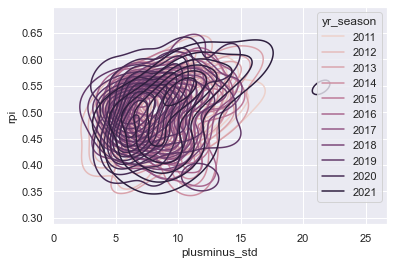

In [99]:
# Distribution plot for point production and RPI
sns.kdeplot(
    data=dffin.reset_index(), 
    x="plusminus_std", 
    y="rpi", 
    hue="yr_season", 
    #fill=True,
)

c:\Users\justi\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='plusminus', ylabel='Density'>

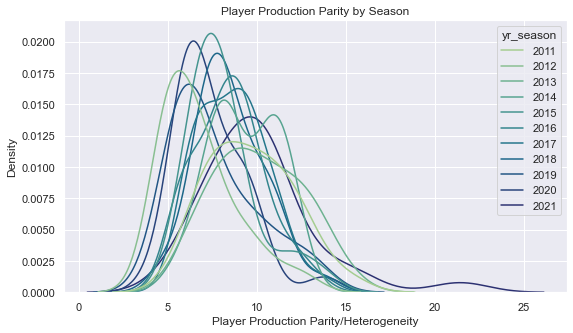

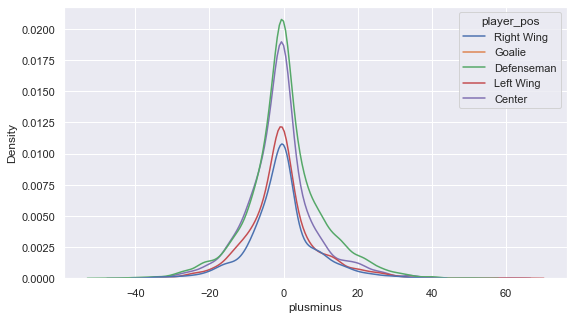

In [59]:
'''
kpi_eval = 'rpi'
plt.figure(figsize=(9,6))
sns.histplot(
    x = "plusminus_std",
    data = dffin,
    bins = 10,
    hue = "yr_season",
    kde = True
).set(title='Player Team Heterogeneity')
'''
plt.figure(figsize=(9,5))
sns.kdeplot(
    x = "plusminus_std",
    data = dffin,
    hue = "yr_season", palette="crest"
).set(
    xlabel = "Player Production Parity/Heterogeneity",
    title = "Player Production Parity by Season"
)

plt.figure(figsize=(9,5))
sns.kdeplot(
    x = "plusminus",
    data = player_summary.reset_index(),
    hue = "player_pos"
)

[Text(0.5, 0, 'Percentile (low-performer)')]

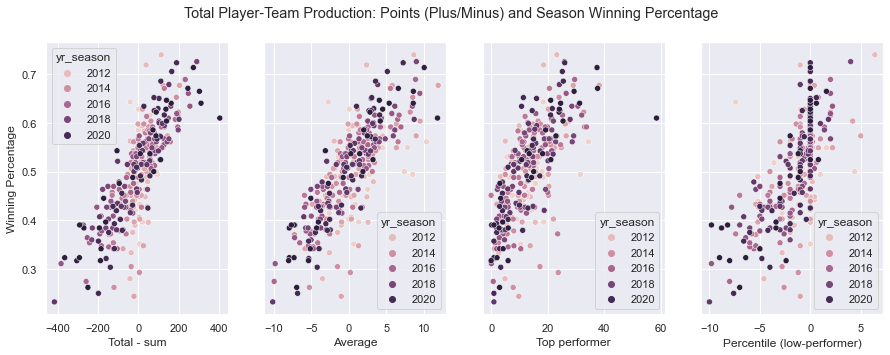

In [34]:
#set seaborn plotting aesthetics as default
sns.set()

kpi_eval = 'wp'
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Total Player-Team Production: Points (Plus/Minus) and Season Winning Percentage')

sns.scatterplot(
    ax=axes[0], 
    data = dffin,
    x = 'plusminus_sum', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Total - sum', ylabel = 'Winning Percentage')

sns.scatterplot(
    ax=axes[1], 
    data = dffin,
    x = 'plusminus_mean', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Average')

sns.scatterplot(
    ax=axes[2], 
    data = dffin,
    x = 'plusminus_percentile_95', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Top performer')

sns.scatterplot(
    ax=axes[3], 
    data = dffin,
    x = 'plusminus_percentile_40', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Percentile (low-performer)')

[Text(0.5, 0, 'Percentile (low-performer)')]

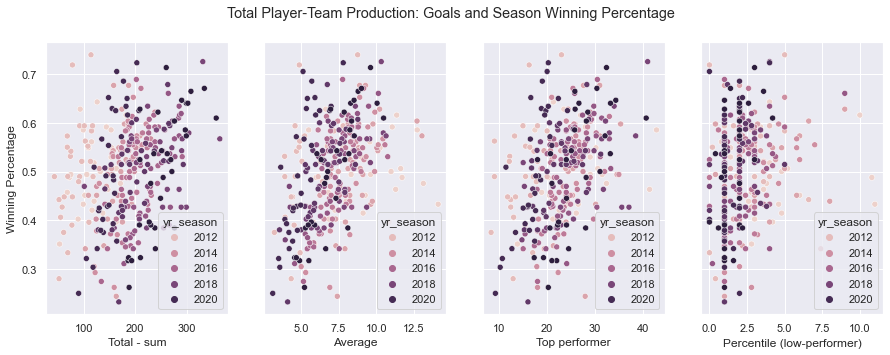

In [35]:
#set seaborn plotting aesthetics as default
sns.set()

kpi_eval = 'wp'
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Total Player-Team Production: Goals and Season Winning Percentage')

sns.scatterplot(
    ax=axes[0], 
    data = dffin,
    x = 'goals_sum', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Total - sum', ylabel = 'Winning Percentage')

sns.scatterplot(
    ax=axes[1], 
    data = dffin,
    x = 'goals_mean', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Average')

sns.scatterplot(
    ax=axes[2], 
    data = dffin,
    x = 'goals_percentile_95', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Top performer')

sns.scatterplot(
    ax=axes[3], 
    data = dffin,
    x = 'goals_percentile_40', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Percentile (low-performer)')

[Text(0.5, 0, 'Percentile (low-performer)')]

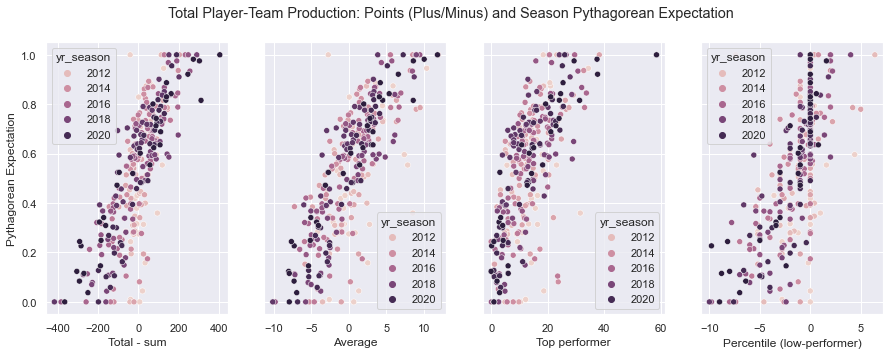

In [36]:
#set seaborn plotting aesthetics as default
sns.set()

kpi_eval = 'kpi_pe'
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Total Player-Team Production: Points (Plus/Minus) and Season Pythagorean Expectation')

sns.scatterplot(
    ax=axes[0], 
    data = dffin,
    x = 'plusminus_sum', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Total - sum', ylabel = 'Pythagorean Expectation')

sns.scatterplot(
    ax=axes[1], 
    data = dffin,
    x = 'plusminus_mean', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Average')

sns.scatterplot(
    ax=axes[2], 
    data = dffin,
    x = 'plusminus_percentile_95', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Top performer')

sns.scatterplot(
    ax=axes[3], 
    data = dffin,
    x = 'plusminus_percentile_40', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Percentile (low-performer)')

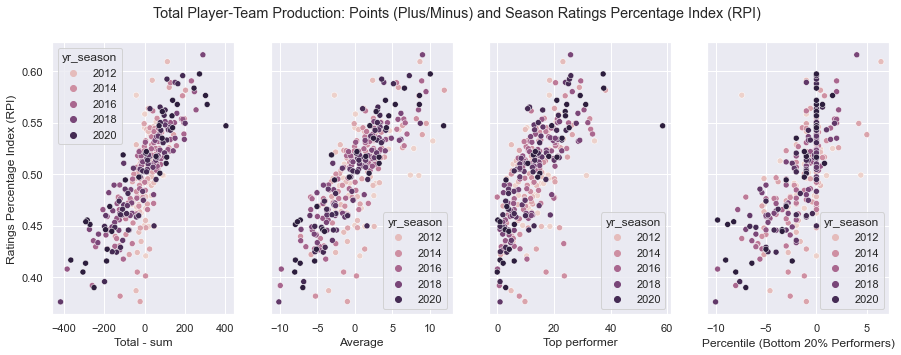

In [71]:
#set seaborn plotting aesthetics as default
sns.set()

kpi_eval = 'rpi'
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Total Player-Team Production: Points (Plus/Minus) and Season Ratings Percentage Index (RPI)')

sns.scatterplot(
    ax=axes[0], 
    data = dffin,
    x = 'plusminus_sum', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Total - sum', ylabel = 'Ratings Percentage Index (RPI)')

sns.scatterplot(
    ax=axes[1], 
    data = dffin,
    x = 'plusminus_mean', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Average')

sns.scatterplot(
    ax=axes[2], 
    data = dffin,
    x = 'plusminus_percentile_95', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Top performer')

sns.scatterplot(
    ax=axes[3], 
    data = dffin,
    x = 'plusminus_percentile_40', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Percentile (Bottom 20% Performers)')

plt.savefig('nhl_playerteam_point to rpi.png')

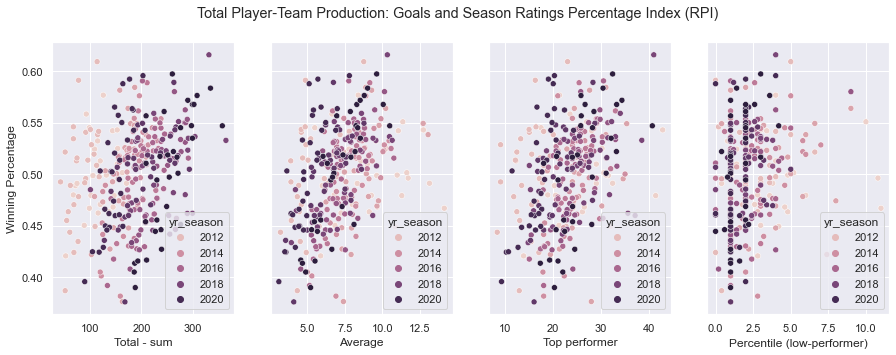

In [72]:
#set seaborn plotting aesthetics as default
sns.set()

kpi_eval = 'rpi'
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Total Player-Team Production: Goals and Season Ratings Percentage Index (RPI)')

sns.scatterplot(
    ax=axes[0], 
    data = dffin,
    x = 'goals_sum', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Total - sum', ylabel = 'Winning Percentage')

sns.scatterplot(
    ax=axes[1], 
    data = dffin,
    x = 'goals_mean', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Average')

sns.scatterplot(
    ax=axes[2], 
    data = dffin,
    x = 'goals_percentile_95', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Top performer')

sns.scatterplot(
    ax=axes[3], 
    data = dffin,
    x = 'goals_percentile_40', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Percentile (low-performer)')

plt.savefig('nhl_playerteam_goals to rpi.png')

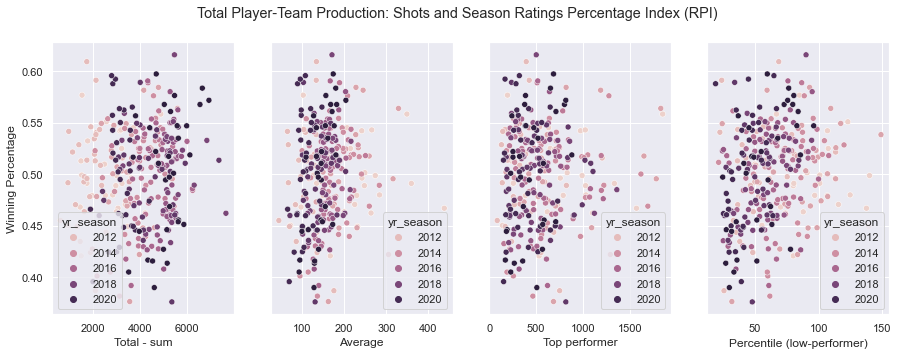

In [73]:
#set seaborn plotting aesthetics as default
sns.set()

kpi_eval = 'rpi'
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Total Player-Team Production: Shots and Season Ratings Percentage Index (RPI)')

sns.scatterplot(
    ax=axes[0], 
    data = dffin,
    x = 'shots_sum', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Total - sum', ylabel = 'Winning Percentage')

sns.scatterplot(
    ax=axes[1], 
    data = dffin,
    x = 'shots_mean', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Average')

sns.scatterplot(
    ax=axes[2], 
    data = dffin,
    x = 'shots_percentile_95', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Top performer')

sns.scatterplot(
    ax=axes[3], 
    data = dffin,
    x = 'shots_percentile_40', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Percentile (low-performer)')

plt.savefig('nhl_playerteam_shot to rpi.png')

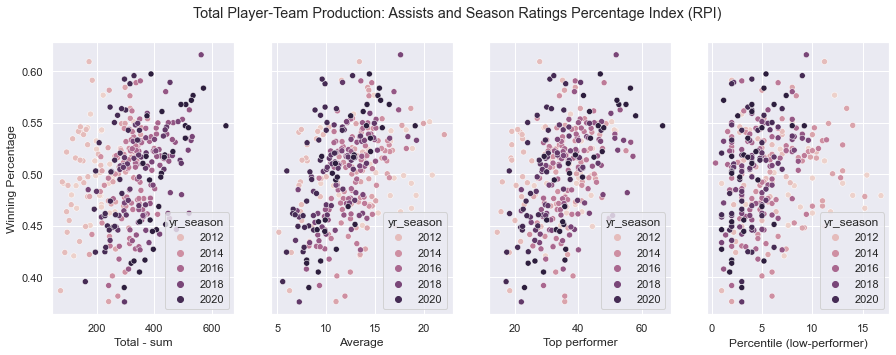

In [74]:
#set seaborn plotting aesthetics as default
sns.set()

kpi_eval = 'rpi'
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Total Player-Team Production: Assists and Season Ratings Percentage Index (RPI)')

sns.scatterplot(
    ax=axes[0], 
    data = dffin,
    x = 'assists_sum', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Total - sum', ylabel = 'Winning Percentage')

sns.scatterplot(
    ax=axes[1], 
    data = dffin,
    x = 'assists_mean', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Average')

sns.scatterplot(
    ax=axes[2], 
    data = dffin,
    x = 'assists_percentile_95', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Top performer')

sns.scatterplot(
    ax=axes[3], 
    data = dffin,
    x = 'assists_percentile_40', y = kpi_eval,
    hue = 'yr_season'
).set(xlabel = 'Percentile (low-performer)')

plt.savefig('nhl_playerteam_assist to rpi.png')

## How parity in player productions impact the team success

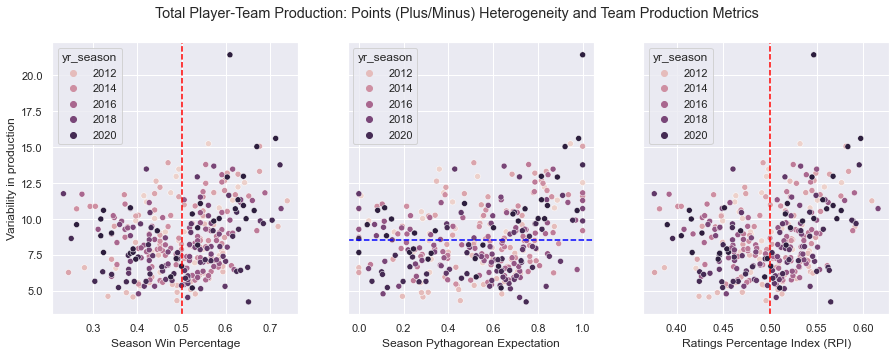

In [75]:
#set seaborn plotting aesthetics as default
sns.set()

kpi_eval = 'rpi'
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Total Player-Team Production: Points (Plus/Minus) Heterogeneity and Team Production Metrics')

axes[0].axvline(0.5, ls='--', c='red')
axes[1].axhline(8.5, ls='--', c='blue')
axes[2].axvline(0.5, ls='--', c='red')

sns.scatterplot(
    ax=axes[0], 
    data = dffin,
    x = 'wp', y = 'plusminus_std',
    hue = 'yr_season'
).set(xlabel = 'Season Win Percentage', ylabel = 'Variability in production')

sns.scatterplot(
    ax=axes[1], 
    data = dffin,
    x = 'kpi_pe', y = 'plusminus_std',
    hue = 'yr_season'
).set(xlabel = 'Season Pythagorean Expectation')

sns.scatterplot(
    ax=axes[2], 
    data = dffin,
    x = 'rpi', y = 'plusminus_std',
    hue = 'yr_season'
).set(xlabel = 'Ratings Percentage Index (RPI)')

plt.savefig('nhl_playerteam_heterogeneity and KPIs.png')

<Figure size 648x432 with 0 Axes>

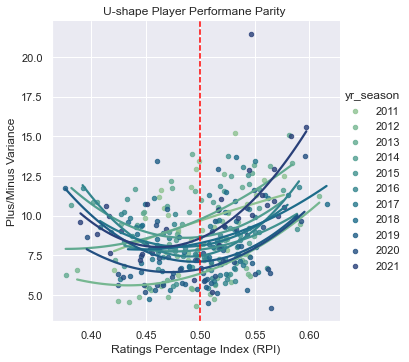

In [76]:
plt.figure(figsize=(9,6))
sns.lmplot(
    data = dffin.reset_index(),
    x = 'rpi', y = 'plusminus_std',hue = 'yr_season', palette="crest",
    order=2, ci=None, scatter_kws={"s": 20}
).set(
    title = "U-shape Player Performane Parity ",
    xlabel = "Ratings Percentage Index (RPI)",
    ylabel = "Plus/Minus Variance"
)

plt.axvline(0.5, ls='--', c='red')

plt.savefig('nhl_playerteam_heterogeneity and KPIs_Ucurve.png')

[Text(0.5, 1.0, 'Player Team Heterogeneity')]

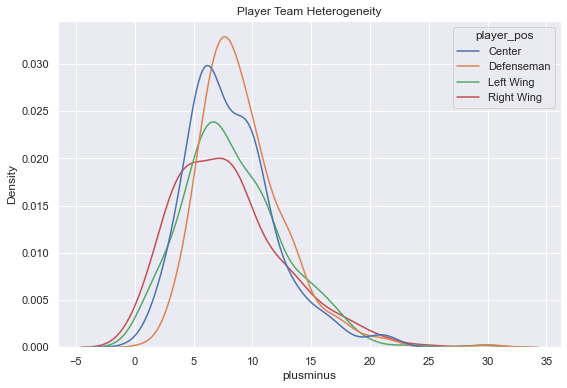

In [87]:
plt.figure(figsize=(9,6))
templot = player_summary \
    .groupby(['player_pos', 'team_triCode', 'yr_season']) \
    .plusminus.std().reset_index()
sns.kdeplot(
    x= "plusminus",            
    data=templot[templot.player_pos != 'Goalie'],
    hue="player_pos"
).set(title='Player Team Heterogeneity by Player Position (excluding Goalies)')
